In [1]:
import os
import pandas as pd
import numpy as np
import csv
import cv2
import yaml
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

%matplotlib widget

In [2]:
data3D_path = r'C:\Users\Yiting\Documents\GitHub\JARVIS-HybridNet\projects\6cam_train_231130\predictions\predictions3D\Predictions_3D_20231201-123801\data3D.csv'
skeleton_path = r'C:\Users\Yiting\Documents\GitHub\JARVIS-HybridNet\projects\6cam_train_231130\config.yaml'

In [13]:
figure_size=(10, 10)
marker_size=30
skeleton_thickness=1

In [4]:
# Import the 3D CSV

# initializing the titles and rows list
fields = []
rows = []

with open(data3D_path, 'r') as f:
    # creating a csv reader object
    data3Dreader = csv.reader(f)
    # extracting field names through first row
    fields = next(data3Dreader)
    bodyparts = []
    for i, bp in enumerate(fields):
        if i%4 == 0: # each
            bodyparts.append(bp)
    num_bodyparts = len(bodyparts)
    next(data3Dreader)
    data3D_points = []
    # extracting each data row one by one
    for row in data3Dreader:
        data3D_points.append([[] for _ in range(3)])
        for ibp in range(num_bodyparts):
            data3D_points[-1][0].append(float(row[ibp*4]))
            data3D_points[-1][1].append(float(row[1+ibp*4]))
            data3D_points[-1][2].append(float(row[2+ibp*4]))
data3D_points = np.array(data3D_points) 
# 1st dimension: # time points
# 2nd dimension: x, y, z
# 3rd dimension: # of body parts

In [5]:
data3D_points.shape

(1367, 3, 12)

In [6]:
vid_path_1 = r'C:\Users\Yiting\Documents\GitHub\JARVIS-HybridNet\projects\6cam_train_231130\visualization\2023-11-21_10-28-08\camTL.mp4'
vid_path_2 = r'C:\Users\Yiting\Documents\GitHub\JARVIS-HybridNet\projects\6cam_train_231130\visualization\2023-11-21_10-28-08\camBL.mp4'


In [7]:
video1 = cv2.VideoCapture(vid_path_1)
video2 = cv2.VideoCapture(vid_path_2)

In [8]:
# Check videos
vid_paths = [vid_path_1, vid_path_2]
for i, path in enumerate(vid_paths):
    print(path)
    if not os.path.exists(path):
        raise ValueError('Provided video file does not exist.')
    video = cv2.VideoCapture(path)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    if skeleton_path is not None:
        with open(skeleton_path, 'r') as yaml_file:
            dic = yaml.safe_load(yaml_file)
            bp_list = dic['KEYPOINT_NAMES']
            bp_connections = dic['SKELETON']
        skeleton = True
    else:
        skeleton = False

    # Check the number of frames vs number of rows in csv
    if num_frames != np.shape(data3D_points)[0]:
        warnings.warn('Number of frames in video ({}) and rows in CSV ({}) are not equal.'
                      ' Check that the paths given are correct.'.format(
            num_frames, np.shape(data3D_points)[0]))

C:\Users\Yiting\Documents\GitHub\JARVIS-HybridNet\projects\6cam_train_231130\visualization\2023-11-21_10-28-08\camTL.mp4
C:\Users\Yiting\Documents\GitHub\JARVIS-HybridNet\projects\6cam_train_231130\visualization\2023-11-21_10-28-08\camBL.mp4


In [9]:
# crop
crop_x = [0,960]
crop_y = [0,960]

In [10]:
bodyparts

['Small_Tip',
 'Small_DIP',
 'Small_PIP',
 'Ring_Tip',
 'Ring_DIP',
 'Ring_PIP',
 'Middle_Tip',
 'Middle_DIP',
 'Middle_PIP',
 'Index_Tip',
 'Index_DIP',
 'Index_PIP']

In [11]:
bp_cmap = ['m', 'b', 'b',
           'm', 'g', 'g',
           'm', 'r', 'r',
           'm', 'c', 'c']

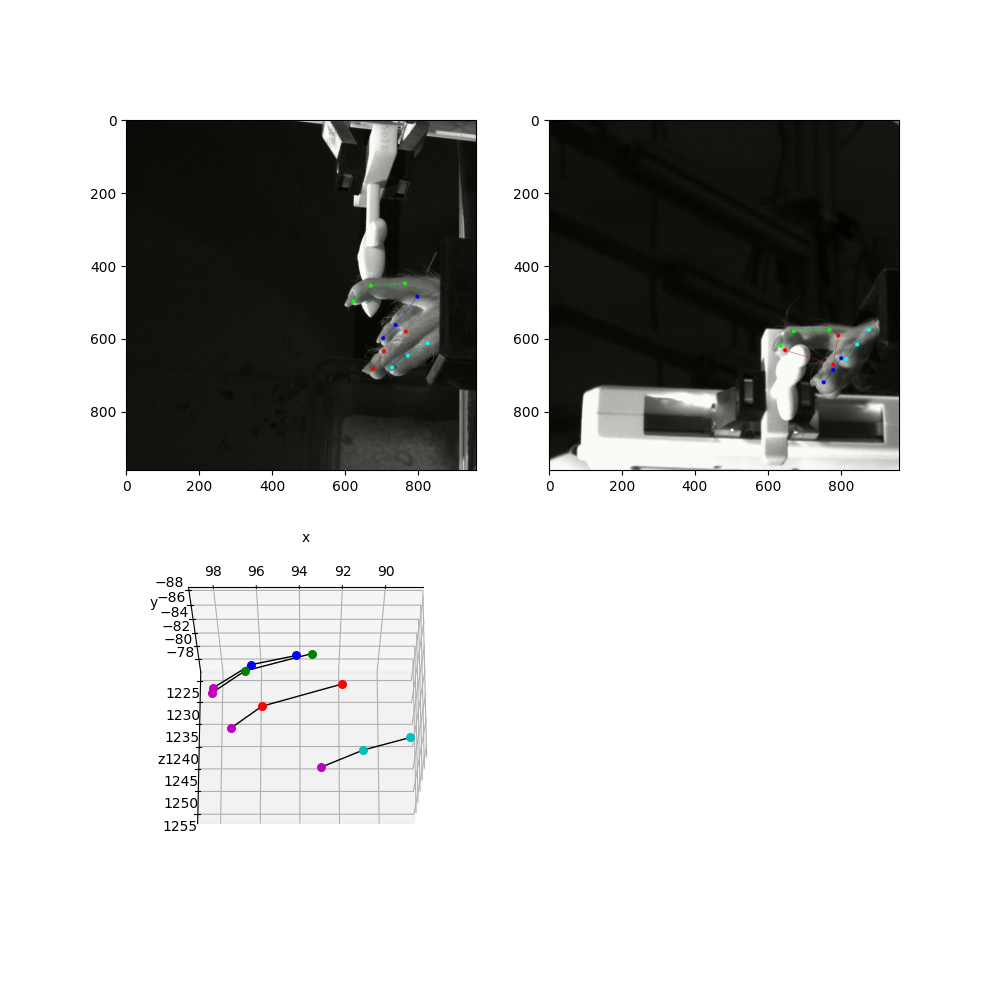

In [18]:
iframe = 700

# Initalize the plots
frame_range = [0, 1000]

# cmap = matplotlib.cm.get_cmap('jet')
# color_idx = np.linspace(0, 1, num_bodyparts)
# bp_cmap = cmap(color_idx)
# Limits in space of the markers + 10%
margin = 1.3
pcntl = 2

x_range = (np.nanpercentile(data3D_points[frame_range[0]:frame_range[1], 0, ibp], pcntl) * margin,
           np.nanpercentile(data3D_points[frame_range[0]:frame_range[1], 0, ibp], 100-pcntl) * margin)
y_range = (np.nanpercentile(data3D_points[frame_range[0]:frame_range[1], 1, ibp], pcntl) * margin,
           np.nanpercentile(data3D_points[frame_range[0]:frame_range[1], 1, ibp], 100-pcntl) * margin)
z_range = (np.nanpercentile(data3D_points[frame_range[0]:frame_range[1], 2, ibp], pcntl) * margin,
           np.nanpercentile(data3D_points[frame_range[0]:frame_range[1], 2, ibp], 100-pcntl) * margin)

FIG = plt.figure(figsize=figure_size)
FIGNUM = plt.gcf().number
AXS = []
AXS.append(FIG.add_subplot(2, 2, 1))
AXS.append(FIG.add_subplot(2, 2, 2))
AXS.append(FIG.add_subplot(2, 2, 3, projection='3d'))
AXS[2].view_init(elev=90, azim=90)

iframe = int(iframe)
plt.figure(FIGNUM)
video1.set(cv2.CAP_PROP_POS_FRAMES, iframe) # Set the frame to get
fe_vid1, frame_vid1 = video1.read() # Read the frame
video2.set(cv2.CAP_PROP_POS_FRAMES, iframe) # Set the frame to get
fe_vid2, frame_vid2 = video2.read() # Read the frame

if fe_vid1 & fe_vid2:
    frame_rgb_vid1 = frame_vid1[..., ::-1].copy()
    frame_rgb_vid2 = frame_vid2[..., ::-1].copy()
    
    AXS[0].cla()
    AXS[0].imshow(frame_rgb_vid1[crop_y[0]:crop_y[1],crop_x[0]:crop_x[1],:])
    
    AXS[1].cla()
    AXS[1].imshow(frame_rgb_vid2[crop_y[0]:crop_y[1],crop_x[0]:crop_x[1],:])
    
    AXS[2].cla()
#     AXS[2].set_xlim(x_range)
#     AXS[2].set_ylim(y_range)
#     AXS[2].set_zlim(z_range)
    AXS[2].set_xlabel('x')
    AXS[2].set_ylabel('y')
    AXS[2].set_zlabel('z')
    

#     # The entire trajectory
#     AXS[2].plot(data3D_points[frame_range[0]:frame_range[1], 0, ibp],
#                 data3D_points[frame_range[0]:frame_range[1], 1, ibp],
#                 data3D_points[frame_range[0]:frame_range[1], 2, ibp],
#                 color='g')
        
    
#     # Position at the current frame
#     AXS[2].scatter(data3D_points[iframe, 0, ibp],
#                    data3D_points[iframe, 1, ibp],
#                    data3D_points[iframe, 2, ibp],
#                    color=bp_cmap[ibp, :], s=marker_size)   
#     AXS[2].view_init(0,0)
    
    # Underlying skeleton
    if skeleton:
        for bpc in bp_connections:
            ibp1 = bp_list.index(bpc[0])
            ibp2 = bp_list.index(bpc[1])

            t_point1 = data3D_points[iframe, :, ibp1]
            t_point2 = data3D_points[iframe, :, ibp2]

            if any(np.isnan(t_point1)) or any(np.isnan(t_point1)):
                continue
            AXS[2].plot([t_point1[0], t_point2[0]],
                        [t_point1[1], t_point2[1]],
                        [t_point1[2], t_point2[2]],
                        color='k', linewidth=skeleton_thickness)

    # Bodypart markers
    for ibp in range(np.size(data3D_points, 2)):
        # Markers
        AXS[2].scatter(data3D_points[iframe, 0, ibp],
                       data3D_points[iframe, 1, ibp],
                       data3D_points[iframe, 2, ibp],
                       color=bp_cmap[ibp],
#                        color=bp_cmap[ibp, :],
                       s=marker_size)
#     AXS[2].view_init(180,180)
    AXS[2].view_init(160,90)
